In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
#Load training image data and labels
train_image_data = np.load(file='Train_image_data.npy')
train_label_data = np.load(file='Train_label_data.npy')

In [3]:
#Load cv image data and labels
cv_image_data = np.load(file='cv_image_data.npy')
cv_label_data = np.load(file='cv_label_data.npy')

In [4]:
#Load test image data and labels
test_image_data = np.load(file='test_image_data.npy')
test_label_data = np.load(file='test_label_data.npy')

In [5]:
print('Training data and label size: ',train_image_data.shape, train_label_data.shape)
print('Cross Validation data and label size: ',cv_image_data.shape, cv_label_data.shape)
print('Test data and label size: ',test_image_data.shape, test_label_data.shape)

Training data and label size:  (384, 128, 128, 3) (384,)
Cross Validation data and label size:  (128, 128, 128, 3) (128,)
Test data and label size:  (128, 128, 128, 3) (128,)


Text(0.5,1,'Image with label 1')

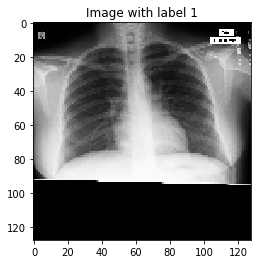

In [6]:
index = 10
plt.imshow(train_image_data[index])
plt.title('Image with label {}'.format(train_label_data[index]))

In [7]:
#flatten data as there are 3 channels - (len,width,3) will be flattened to (len*width*3,1) for 1 example.
#For all training data, it will be (len*width*3,#examples)

#train_set_x_flatten = train_image_data.reshape(train_image_data.shape[0],-1).T
#cv_set_x_flatten = cv_image_data.reshape(cv_image_data.shape[0],-1).T
#test_set_x_flatten = test_image_data.reshape(test_image_data.shape[0],-1).T

In [8]:
#print('Training data shape after flattening: ',train_set_x_flatten.shape)
#print('Cross Validation shape after flattening: ',cv_set_x_flatten.shape)
#print('Test data shape after flattening: ',test_set_x_flatten.shape)

In [9]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [10]:
sample = train_label_data[0]

In [11]:
#Normalize data
X_train = train_image_data/255.
X_cv    = cv_image_data/255.
X_test  = test_image_data/255.

Y_train = convert_to_one_hot(train_label_data, 2).T
Y_cv = convert_to_one_hot(cv_label_data, 2).T
Y_test = convert_to_one_hot(test_label_data, 2).T

In [12]:
print('Training label data shape after converting: ',Y_train.shape)
print('Cross label data shape after converting: ',Y_cv.shape)
print('Test label data shape after converting: ',Y_test.shape)

Training label data shape after converting:  (384, 2)
Cross label data shape after converting:  (128, 2)
Test label data shape after converting:  (128, 2)


In [23]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(dtype='float',shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(dtype='float',shape=(None,n_y))
    
    return X,Y

In [14]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1":W1, "W2": W2}
    
    return parameters

In [15]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,[1,1,1,1],'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,[1,8,8,1],[1,8,8,1],'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,[1,1,1,1],'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,[1,4,4,1],[1,4,4,1],'SAME')
    
    # Flatten
    P2 = tf.contrib.layers.flatten(P2)
    
    # 2 neurons in output layer
    Z3 = tf.contrib.layers.fully_connected(P2,2,activation_fn=None)
    
    return Z3

In [16]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [17]:
from tensorflow.python.framework import ops

In [46]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, print_cost = True):
    
    # to be able to rerun the model without overwriting tf variables 
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3 
    
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X,parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            _, temp_cost = sess.run([optimizer,cost],feed_dict={X:X_train,Y:Y_train})
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, temp_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(temp_cost)
        
        #plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Cross validation set Accuracy:", test_accuracy)
        
        #save model
        filepath = os.path.join(os.getcwd(), 'Bronchitis')
        tf.train.Saver().save(sess,filepath)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 0.763793
Cost after epoch 5: 0.692900
Cost after epoch 10: 0.690774
Cost after epoch 15: 0.689059
Cost after epoch 20: 0.686498
Cost after epoch 25: 0.682379
Cost after epoch 30: 0.676964
Cost after epoch 35: 0.670642
Cost after epoch 40: 0.663531
Cost after epoch 45: 0.656050
Cost after epoch 50: 0.648391
Cost after epoch 55: 0.639720
Cost after epoch 60: 0.630513
Cost after epoch 65: 0.619596
Cost after epoch 70: 0.606631


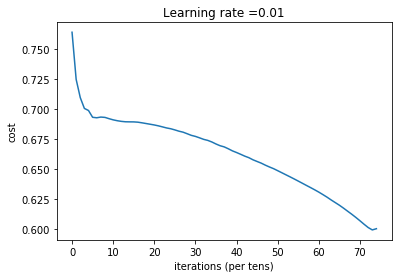

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6510417
Cross validation set Accuracy: 0.5078125


In [49]:
_, _, parameters = model(X_train, Y_train, X_cv, Y_cv,learning_rate = 0.01,num_epochs=75)

In [42]:
# test the model with a random image from test set
test_index = np.random.randint(0,X_test.shape[0])
img = X_test[test_index]

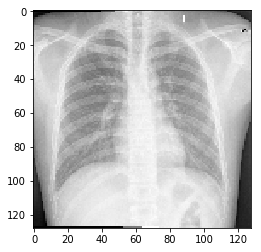

In [43]:
plt.imshow(img)

In [59]:
# get accuracy on X_test and Y_test
def predict(X_test,Y_test):
    
    with tf.Session() as sess:
        
        (m, n_H0, n_W0, n_C0) = X_test.shape
        n_y = Y_test.shape[1]
    
        X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
        tf.train.Saver().restore(sess,'Bronchitis')
        predictions = sess.run(Y_test, feed_dict={X:X_test})
        
    return predictions

In [61]:
#preds = predict(X_test,Y_test)